In [53]:
import torch
import os
import pickle as pkl
import numpy as np
import torchvision
import itertools
import matplotlib.pyplot as plt
from certificate_methods import *
from utils import ReducedModel, parse
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import cv2

In [54]:


def scale_batch_images(batch, min_val=0, max_val=1):
    """
    Scales a batch of PyTorch tensors (images) to the specified range [min_val, max_val].

    Args:
        batch (torch.Tensor): A batch of PyTorch tensors (images) to be scaled with shape (batch_size, channels, height, width)
        min_val (float, optional): Minimum value of the target range. Defaults to 0.
        max_val (float, optional): Maximum value of the target range. Defaults to 1.

    Returns:
        torch.Tensor: A new batch of PyTorch tensors with values scaled to the specified range
    """

    batch_min = torch.amin(batch, dim=(1, 2, 3), keepdim=True)
    batch_max = torch.amax(batch, dim=(1, 2, 3), keepdim=True)

    # Normalize the batch of images to [0, 1] range
    normalized_batch = (batch - batch_min) / (batch_max - batch_min)

    # Scale the normalized batch to the target range [min_val, max_val]
    scaled_batch = normalized_batch * (max_val - min_val) + min_val

    return scaled_batch

def man_transform(masked_imgs):
    transformed_images = []
    for img in masked_imgs:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1)
        timg = torch.tensor(img).unsqueeze(0)  # Add an extra dimension to make it a batch of size 1
    

        normalized_image = (timg/torch.max(timg)- mean) / std
        normalized_image = normalized_image [0]
    

        transformed_images.append(normalized_image)
    stacked_images = torch.stack(transformed_images, dim=0)
    return stacked_images

# Example usage:
# Assuming 'input_batch' is a PyTorch tensor of shape (batch_size, channels, height, width)
# scaled_batch = scale_batch_images(input_batch, 0, 1)
def evaluate(model, images, labels):
        with torch.no_grad():
            outputs = model(images)
            output_probs = torch.nn.Softmax(dim = 1)(outputs).detach().cpu().numpy()
        output_labels = np.argmax(output_probs, axis = 1)
        print(output_labels)
        print(labels)
        correct = np.sum(output_labels == labels.numpy())
        total = len(labels)
        print(f"{correct}/{total}: {correct / total}")


## Load model

In [55]:
model = torchvision.models.resnet50(pretrained=False).cuda()
model.load_state_dict(torch.utils.model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## load sample images and labels

In [68]:
npy_images = "/home/abka03/IML/soundness_saliency/input_data/sample_images.npy"
all_images = torch.from_numpy(np.load(os.path.join(npy_images)))[6:7]
all_images = scale_batch_images(all_images)
npy_labels = "/home/abka03/IML/soundness_saliency/input_data/sample_labels.npy"
labels = torch.from_numpy(np.load(os.path.join(npy_labels)))[6:7]
input_images = man_transform(all_images).cuda()
evaluate(model, input_images, labels)

[851]
tensor([851])
1/1: 1.0


/home/abka03/thesis-env/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Plot the sample images

AttributeError: 'AxesSubplot' object has no attribute 'flat'

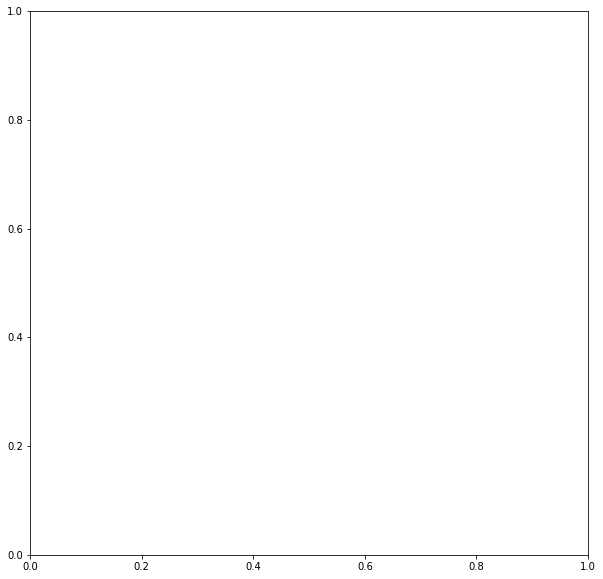

In [69]:
sample = all_images
def plot_image_grid(images_array):
    """
    Plots a grid of images from a NumPy array.

    Args:
    images_array (numpy.ndarray): A NumPy array of images with shape (num_images, height, width) or (num_images, height, width, channels)
    """

    # Determine the grid size based on the number of images
    grid_size = int(np.ceil(np.sqrt(len(images_array))))

    # Create the figure and axes objects
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    # Iterate through the axes and plot the images
    for i, ax in enumerate(axes.flat):
        if i < len(images_array):
            # Remove x-axis and y-axis ticks
            ax.set_xticks([])
            ax.set_yticks([])

            # Plot the image on the current axis
            if images_array.shape[1] == 1:
                img = images_array[i][0] 
            else:
                img = np.transpose(images_array[i], (1, 2, 0))

            ax.imshow(img, cmap='gray' if images_array.shape[1] == 1 else None)
        else:
            # Remove the empty subplot
            fig.delaxes(ax)

    # Add space between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Display the grid of images
plot_image_grid(sample)

## Noise base. It is the baseline for removing feature

In [59]:
noise_images = torch.from_numpy(np.load('./noise_images.npy'))
print("Number of noise image: " , len(noise_images))
# Use grey:
noise_images = None
#print(noise_images.shape)

Number of noise image:  100


In [70]:
images = all_images#[0:5] # chose 5 images for demonstration
K = 1
scale = 2
lr = 0.1
steps = 3000
obj = 'ent'
noise_bs = 10
reg_l1 = 2e-05
reg_tv = 0.01
reg_ent = 0.0
debug = True


In [71]:
with torch.no_grad():
    outputs = model(images.cuda())
    output_probs = torch.nn.Softmax(dim = 1)(outputs).detach().cpu().numpy()
print("Total classes in the model: ", len(output_probs[0]))
output_labels = np.argmax(output_probs, axis = 1)
probs = torch.zeros(images.shape[0], 1000)
for target_label in output_labels:
    probs[:, target_label] = 1
batch_masked_model = learn_masks_for_batch_Kcert(
                model, images, target_probs=probs, K=K, scale=scale,
                opt=optim.Adam, lr=lr, steps=steps, obj=obj,
                noise_mean=None, noise_batch=noise_images, noise_bs=noise_bs,
                reg_l1=reg_l1, reg_tv=reg_tv, reg_ent=reg_ent, old_mask=None, debug=debug)
masks = batch_masked_model.mask().detach().cpu()[:-1]
            

Total classes in the model:  1000
1 2 0.1 3000 ent 10 2e-05 0.01 0.0
2999: loss: 0.04, l1 norm: 1430, tv: 1.36, ent: 0.12, pred prob: 0.9999


In [90]:
output  = batch_masked_model(model, all_images.cuda(), masks=masks.cuda())[0]

np_output = output.cpu().detach()
o = np.argmax(np_output)
print(o)

tensor(921)


In [72]:
heatmap = masks[0]
print(heatmap.shape)

# normalize heatmap 
heatmap = scale_batch_images(heatmap)

print(torch.max(heatmap[0][0]))

torch.Size([1, 1, 224, 224])
tensor(1.)


AttributeError: 'AxesSubplot' object has no attribute 'flat'

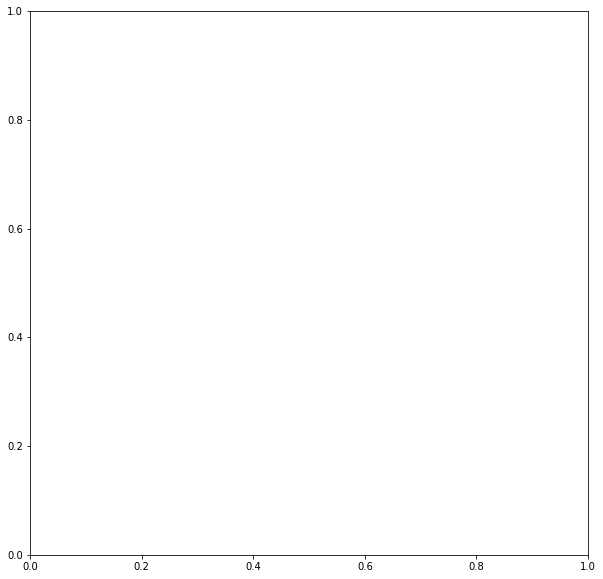

In [73]:


def scale_image_to_255(image_array):
    """
    Scales the input image array to the range [0, 255].

    Args:
        image_array (np.array): A NumPy array representing an image

    Returns:
        np.array: A new NumPy array with pixel values scaled to the range [0, 255]
    """
    print(image_array)
    # Find the minimum and maximum pixel values
    min_val = np.min(image_array)
    max_val = np.max(image_array)
    # Scale the image array to the range [0, 255]
    scaled_image_array = 255 * (image_array - min_val) / (max_val - min_val)

    return scaled_image_array


def plot_image_grid(images_array):
    """
    Plots a grid of images from a NumPy array.

    Args:
    images_array (numpy.ndarray): A NumPy array of images with shape (num_images, height, width) or (num_images, height, width, channels)
    """

    # Determine the grid size based on the number of images
    grid_size = int(np.ceil(np.sqrt(len(images_array))))

    # Create the figure and axes objects
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    # Iterate through the axes and plot the images
    for i, ax in enumerate(axes.flat):
        if i < len(images_array):
            # Remove x-axis and y-axis ticks
            ax.set_xticks([])
            ax.set_yticks([])

            # Plot the image on the current axis
            if images_array.shape[1] == 1:
                img = images_array[i][0] 
            else:
                img = np.transpose(images_array[i], (1, 2, 0))

            ax.imshow(img, cmap='gray' if images_array.shape[1] == 1 else None)
        else:
            # Remove the empty subplot
            fig.delaxes(ax)

    # Add space between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Display the grid of images
    plt.show()
plot_image_grid(heatmap)
plot_image_grid(images.numpy())

tensor(1.)


AttributeError: 'AxesSubplot' object has no attribute 'flat'

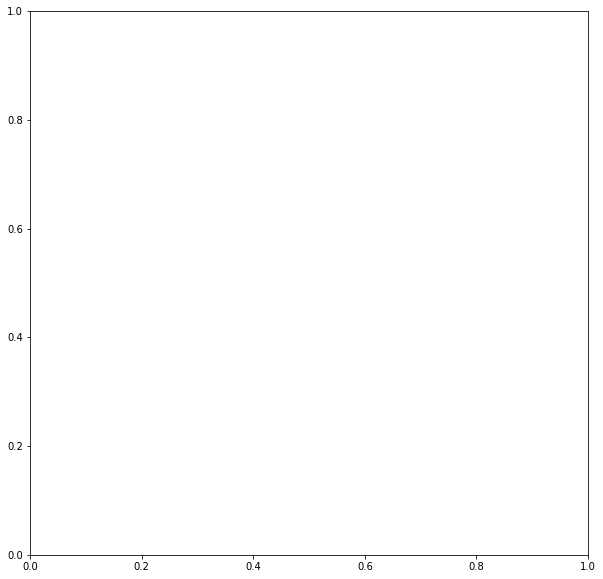

In [74]:


def apply_masks_to_images(images_list, masks_list):
    """
    Applies individual single-channel masks to a list of channel-first 3-channel images.

    Args:
        images_list (list of np.array): A list of channel-first 3-channel images, each with shape (3, height, width)
        masks_list (list of np.array): A list of single-channel masks, each with shape (height, width)

    Returns:
        list of np.array: A list of masked channel-first images, each with shape (3, height, width)
    """

    if len(images_list) != len(masks_list):
        raise ValueError("The number of images and masks must be equal")

    masked_images = []

    for image, mask in zip(images_list, masks_list):
        if len(image.shape) != 3 or image.shape[0] != 3:
            raise ValueError("Each input image must have a shape of (3, height, width)")

        if len(mask.shape) != 3:
            raise ValueError("Each input mask must have a shape of (channel, height, width)")

        # Expand the mask to match the shape of the image
        s_mask = mask[0]
        expanded_mask = np.repeat(s_mask[np.newaxis, :, :], 3, axis=0)
        # Multiply the image with the expanded mask
        masked_image = image * expanded_mask

        # Add the masked image to the list
        masked_images.append(masked_image)
    masked_images = np.stack(masked_images, axis=0)
    return torch.tensor(masked_images)
masked_imgs = apply_masks_to_images(images, heatmap)

masked_image = scale_batch_images(masked_imgs)

print(torch.max(masked_image))
plot_image_grid(masked_image)


In [78]:
print("Masked images shape: ", masked_image.shape)
print("Masked image max, min: ", torch.max(masked_image), torch.min(masked_image))
masked_input = man_transform(masked_image).clone().detach().cuda()
acc = evaluate(model, masked_input, labels)


Masked images shape:  torch.Size([1, 3, 224, 224])
Masked image max, min:  tensor(1.) tensor(0.)
[921]
tensor([851])
0/1: 0.0


/home/abka03/thesis-env/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
